In [1]:
import pandas as pd
import matplotlib as ml
import numpy as np
import math as mt
import pprint
pp = pprint.PrettyPrinter(width=41, compact=True)
pd.set_option('display.max_rows',500)
pd.set_option('display.max_columns',50)


In [7]:
data=pd.read_csv("C:/Users/Roger/OneDrive/ESPECIAL/IA006/python/daily-minimum-temperatures.csv")
data=data.sort_values('Date')
data['Date'] = pd.to_datetime(data['Date'])
data['Year']=data['Date'].dt.year
data=data[['Year','Date','Temp']]
print(data.describe())

              Year         Temp
count  3650.000000  3650.000000
mean   1985.500000    11.177753
std       2.872675     4.071837
min    1981.000000     0.000000
25%    1983.000000     8.300000
50%    1985.500000    11.000000
75%    1988.000000    14.000000
max    1990.000000    26.300000


In [3]:
#normalizando a temperatura para ficar dentro do range [-2,2]
tmin=data.Temp.min()
tmax=data.Temp.max()
data_windowed=data.copy()
data_windowed['TempNorm']=(data['Temp']-tmin)/(tmax-tmin)*4-2
#gerando os 5 atrasos
for k in range(1,6) :
     colum_name='T-'+str(k)
     data_windowed[colum_name]=data_windowed['TempNorm'].shift(k)
data_windowed=data_windowed.iloc[5:].copy()
data_windowed.index = pd.RangeIndex(len(data_windowed.index))
data_windowed.describe()

,Year,Temp,TempNorm,T-1,T-2,T-3,T-4,T-5
count,3645.000000,3645.000000,3645.000000,3645.000000,3645.000000,3645.000000,3645.000000,3645.000000
mean,1985.506173,11.168999,-0.301293,-0.301176,-0.301222,-0.301001,-0.300821,-0.300542
std,2.869801,4.066967,0.618550,0.618643,0.618598,0.618869,0.619071,0.619495
min,1981.000000,0.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000
25%,1983.000000,8.300000,-0.737643,-0.737643,-0.737643,-0.737643,-0.737643,-0.737643
50%,1986.000000,11.000000,-0.326996,-0.326996,-0.326996,-0.326996,-0.326996,-0.326996
75%,1988.000000,14.000000,0.129278,0.129278,0.129278,0.129278,0.129278,0.129278
max,1990.000000,26.300000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000


In [4]:
#
#configuraçõeos do método
ano_teste=1990
atrasos=100
lista_folders=[4]
# lista_lambda=[0,0.1]
lista_lambda=[0,0.000976563,0.001953125,0.00390625,0.0078125,0.015625,0.03125,0.0625,0.125,0.25,0.5,1,2,4,8,16,32,64,128,256,512,1024]
#gera os dados de treino e teste
data_train=data_windowed[data_windowed['Year']!=ano_teste].copy()
# print(data_train.head())
data_test=data_windowed[data_windowed['Year']==ano_teste].copy()
#inicia os testes
resultados=pd.DataFrame(columns=['T','Lambda','Folder','Dado Treino','Dado Validação','Matrix','Erro Treino','Erro Validação','Erro Teste'])
linha=0
for folders in lista_folders:
    #gerando uma coluna com o número de folds a partir de uma distribuição normal e inteiros
    y_teste=data_test.iloc[:,2:3].copy()
    x_teste=data_test.iloc[:,4:9].copy()
    data_train['fold'] = np.random.randint(1,folders+1,size=len(data_train))
    for k in range(1,atrasos+1):
        for la in lista_lambda:
            for f in range(1,folders+1):
                print("Regressão:Lambda {} K {}".format(la,k))
                linha+=1
                resultados.loc[linha,'T']=k
                resultados.loc[linha,'Lambda']=la
                resultados.loc[linha,'Folder']=f
                
                #Dados treino
                x_treino=data_train[data_train['fold']!=f]
                x_treino=x_treino.iloc[:,4:9].copy()
                y_treino=data_train[data_train['fold']!=f]
                y_treino=y_treino.iloc[:,2:3].copy()

                #Dados validação
                x_valida=data_train[data_train['fold']==f]
                x_valida=x_valida.iloc[:,4:9].copy()
                y_valida=data_train[data_train['fold']==f]
                y_valida=y_valida.iloc[:,2:3].copy()
                
                # criando a matrix aleatória
                w_temp=pd.DataFrame(columns=['w'])
                w=pd.DataFrame(columns=['w1'])
                variable_list=[]
                for t in range(0,k):
                    #criando o vetor w     
                    for l in range(0,5):
                        w_temp.loc[l,'w']=np.random.uniform(0, 1)
                    #Normalizando o vetor w para que sua soma seja 1
                    w_temp['w']=w_temp['w']/w_temp['w'].sum()
                    colum_name='w'+str(t+1)
                    variable_name='xl_'+str(t+1)
                    variable_list.append(variable_name)
                    w[colum_name]=w_temp['w']
                
                #criando as novas variaveis
                xl_treino=pd.DataFrame(np.tanh(np.float_(np.dot(x_treino,w))),columns=variable_list)
                xl_treino['C']=1;
                xl_valida=pd.DataFrame(np.tanh(np.float_(np.dot(x_valida,w))),columns=variable_list)
                xl_valida['C']=1;
                #criação da matrix identidade
                i=np.identity(k+1)
                i[k,k]=0
                
                #cálculo do vetor b para regressão
                xtx=(xl_treino.values.transpose()).dot(xl_treino.values)
                xtxinv=np.linalg.pinv(xtx+la*i)
                b=(xtxinv.dot(xl_treino.transpose())).dot(y_treino) 
                
                #erro treino
                yh_treino=(xl_treino.values).dot(b)
                yh_treino_df=pd.DataFrame(yh_treino,columns=['Temp'])
                y_treino.index = pd.RangeIndex(len(y_treino.index))
                error_train=mt.sqrt(((yh_treino_df-y_treino)**2).mean())
                resultados.loc[linha,'Erro Treino']=error_train
                
                #erro validação
                yh_valida=(xl_valida.values).dot(b)
                yh_valida_df=pd.DataFrame(yh_valida,columns=['Temp'])
                y_valida.index = pd.RangeIndex(len(y_valida.index))
                error_valid=mt.sqrt(((yh_valida_df-y_valida)**2).mean())
                resultados.loc[linha,'Erro Validação']=error_valid
# leitura dos resultados
print(resultados[['T','Lambda','Folder','Erro Treino','Erro Validação']])




Regressão:Lambda 0 K 1
Regressão:Lambda 0 K 1
Regressão:Lambda 0 K 1
Regressão:Lambda 0 K 1
Regressão:Lambda 0.000976563 K 1
Regressão:Lambda 0.000976563 K 1
Regressão:Lambda 0.000976563 K 1
Regressão:Lambda 0.000976563 K 1
Regressão:Lambda 0.001953125 K 1
Regressão:Lambda 0.001953125 K 1
Regressão:Lambda 0.001953125 K 1
Regressão:Lambda 0.001953125 K 1
Regressão:Lambda 0.00390625 K 1
Regressão:Lambda 0.00390625 K 1
Regressão:Lambda 0.00390625 K 1
Regressão:Lambda 0.00390625 K 1
Regressão:Lambda 0.0078125 K 1
Regressão:Lambda 0.0078125 K 1
Regressão:Lambda 0.0078125 K 1
Regressão:Lambda 0.0078125 K 1
Regressão:Lambda 0.015625 K 1
Regressão:Lambda 0.015625 K 1
Regressão:Lambda 0.015625 K 1
Regressão:Lambda 0.015625 K 1
Regressão:Lambda 0.03125 K 1
Regressão:Lambda 0.03125 K 1
Regressão:Lambda 0.03125 K 1
Regressão:Lambda 0.03125 K 1
Regressão:Lambda 0.0625 K 1
Regressão:Lambda 0.0625 K 1
Regressão:Lambda 0.0625 K 1
Regressão:Lambda 0.0625 K 1
Regressão:Lambda 0.125 K 1
Regressão:Lambda 

Regressão:Lambda 1 K 4
Regressão:Lambda 1 K 4
Regressão:Lambda 1 K 4
Regressão:Lambda 1 K 4
Regressão:Lambda 2 K 4
Regressão:Lambda 2 K 4
Regressão:Lambda 2 K 4
Regressão:Lambda 2 K 4
Regressão:Lambda 4 K 4
Regressão:Lambda 4 K 4
Regressão:Lambda 4 K 4
Regressão:Lambda 4 K 4
Regressão:Lambda 8 K 4
Regressão:Lambda 8 K 4
Regressão:Lambda 8 K 4
Regressão:Lambda 8 K 4
Regressão:Lambda 16 K 4
Regressão:Lambda 16 K 4
Regressão:Lambda 16 K 4
Regressão:Lambda 16 K 4
Regressão:Lambda 32 K 4
Regressão:Lambda 32 K 4
Regressão:Lambda 32 K 4
Regressão:Lambda 32 K 4
Regressão:Lambda 64 K 4
Regressão:Lambda 64 K 4
Regressão:Lambda 64 K 4
Regressão:Lambda 64 K 4
Regressão:Lambda 128 K 4
Regressão:Lambda 128 K 4
Regressão:Lambda 128 K 4
Regressão:Lambda 128 K 4
Regressão:Lambda 256 K 4
Regressão:Lambda 256 K 4
Regressão:Lambda 256 K 4
Regressão:Lambda 256 K 4
Regressão:Lambda 512 K 4
Regressão:Lambda 512 K 4
Regressão:Lambda 512 K 4
Regressão:Lambda 512 K 4
Regressão:Lambda 1024 K 4
Regressão:Lambda 1

Regressão:Lambda 0.000976563 K 8
Regressão:Lambda 0.000976563 K 8
Regressão:Lambda 0.001953125 K 8
Regressão:Lambda 0.001953125 K 8
Regressão:Lambda 0.001953125 K 8
Regressão:Lambda 0.001953125 K 8
Regressão:Lambda 0.00390625 K 8
Regressão:Lambda 0.00390625 K 8
Regressão:Lambda 0.00390625 K 8
Regressão:Lambda 0.00390625 K 8
Regressão:Lambda 0.0078125 K 8
Regressão:Lambda 0.0078125 K 8
Regressão:Lambda 0.0078125 K 8
Regressão:Lambda 0.0078125 K 8
Regressão:Lambda 0.015625 K 8
Regressão:Lambda 0.015625 K 8
Regressão:Lambda 0.015625 K 8
Regressão:Lambda 0.015625 K 8
Regressão:Lambda 0.03125 K 8
Regressão:Lambda 0.03125 K 8
Regressão:Lambda 0.03125 K 8
Regressão:Lambda 0.03125 K 8
Regressão:Lambda 0.0625 K 8
Regressão:Lambda 0.0625 K 8
Regressão:Lambda 0.0625 K 8
Regressão:Lambda 0.0625 K 8
Regressão:Lambda 0.125 K 8
Regressão:Lambda 0.125 K 8
Regressão:Lambda 0.125 K 8
Regressão:Lambda 0.125 K 8
Regressão:Lambda 0.25 K 8
Regressão:Lambda 0.25 K 8
Regressão:Lambda 0.25 K 8
Regressão:Lambda

Regressão:Lambda 0.5 K 11
Regressão:Lambda 1 K 11
Regressão:Lambda 1 K 11
Regressão:Lambda 1 K 11
Regressão:Lambda 1 K 11
Regressão:Lambda 2 K 11
Regressão:Lambda 2 K 11
Regressão:Lambda 2 K 11
Regressão:Lambda 2 K 11
Regressão:Lambda 4 K 11
Regressão:Lambda 4 K 11
Regressão:Lambda 4 K 11
Regressão:Lambda 4 K 11
Regressão:Lambda 8 K 11
Regressão:Lambda 8 K 11
Regressão:Lambda 8 K 11
Regressão:Lambda 8 K 11
Regressão:Lambda 16 K 11
Regressão:Lambda 16 K 11
Regressão:Lambda 16 K 11
Regressão:Lambda 16 K 11
Regressão:Lambda 32 K 11
Regressão:Lambda 32 K 11
Regressão:Lambda 32 K 11
Regressão:Lambda 32 K 11
Regressão:Lambda 64 K 11
Regressão:Lambda 64 K 11
Regressão:Lambda 64 K 11
Regressão:Lambda 64 K 11
Regressão:Lambda 128 K 11
Regressão:Lambda 128 K 11
Regressão:Lambda 128 K 11
Regressão:Lambda 128 K 11
Regressão:Lambda 256 K 11
Regressão:Lambda 256 K 11
Regressão:Lambda 256 K 11
Regressão:Lambda 256 K 11
Regressão:Lambda 512 K 11
Regressão:Lambda 512 K 11
Regressão:Lambda 512 K 11
Regr

Regressão:Lambda 512 K 14
Regressão:Lambda 512 K 14
Regressão:Lambda 1024 K 14
Regressão:Lambda 1024 K 14
Regressão:Lambda 1024 K 14
Regressão:Lambda 1024 K 14
Regressão:Lambda 0 K 15
Regressão:Lambda 0 K 15
Regressão:Lambda 0 K 15
Regressão:Lambda 0 K 15
Regressão:Lambda 0.000976563 K 15
Regressão:Lambda 0.000976563 K 15
Regressão:Lambda 0.000976563 K 15
Regressão:Lambda 0.000976563 K 15
Regressão:Lambda 0.001953125 K 15
Regressão:Lambda 0.001953125 K 15
Regressão:Lambda 0.001953125 K 15
Regressão:Lambda 0.001953125 K 15
Regressão:Lambda 0.00390625 K 15
Regressão:Lambda 0.00390625 K 15
Regressão:Lambda 0.00390625 K 15
Regressão:Lambda 0.00390625 K 15
Regressão:Lambda 0.0078125 K 15
Regressão:Lambda 0.0078125 K 15
Regressão:Lambda 0.0078125 K 15
Regressão:Lambda 0.0078125 K 15
Regressão:Lambda 0.015625 K 15
Regressão:Lambda 0.015625 K 15
Regressão:Lambda 0.015625 K 15
Regressão:Lambda 0.015625 K 15
Regressão:Lambda 0.03125 K 15
Regressão:Lambda 0.03125 K 15
Regressão:Lambda 0.03125 K 1

Regressão:Lambda 0.03125 K 18
Regressão:Lambda 0.0625 K 18
Regressão:Lambda 0.0625 K 18
Regressão:Lambda 0.0625 K 18
Regressão:Lambda 0.0625 K 18
Regressão:Lambda 0.125 K 18
Regressão:Lambda 0.125 K 18
Regressão:Lambda 0.125 K 18
Regressão:Lambda 0.125 K 18
Regressão:Lambda 0.25 K 18
Regressão:Lambda 0.25 K 18
Regressão:Lambda 0.25 K 18
Regressão:Lambda 0.25 K 18
Regressão:Lambda 0.5 K 18
Regressão:Lambda 0.5 K 18
Regressão:Lambda 0.5 K 18
Regressão:Lambda 0.5 K 18
Regressão:Lambda 1 K 18
Regressão:Lambda 1 K 18
Regressão:Lambda 1 K 18
Regressão:Lambda 1 K 18
Regressão:Lambda 2 K 18
Regressão:Lambda 2 K 18
Regressão:Lambda 2 K 18
Regressão:Lambda 2 K 18
Regressão:Lambda 4 K 18
Regressão:Lambda 4 K 18
Regressão:Lambda 4 K 18
Regressão:Lambda 4 K 18
Regressão:Lambda 8 K 18
Regressão:Lambda 8 K 18
Regressão:Lambda 8 K 18
Regressão:Lambda 8 K 18
Regressão:Lambda 16 K 18
Regressão:Lambda 16 K 18
Regressão:Lambda 16 K 18
Regressão:Lambda 16 K 18
Regressão:Lambda 32 K 18
Regressão:Lambda 32 K

Regressão:Lambda 32 K 21
Regressão:Lambda 32 K 21
Regressão:Lambda 32 K 21
Regressão:Lambda 32 K 21
Regressão:Lambda 64 K 21
Regressão:Lambda 64 K 21
Regressão:Lambda 64 K 21
Regressão:Lambda 64 K 21
Regressão:Lambda 128 K 21
Regressão:Lambda 128 K 21
Regressão:Lambda 128 K 21
Regressão:Lambda 128 K 21
Regressão:Lambda 256 K 21
Regressão:Lambda 256 K 21
Regressão:Lambda 256 K 21
Regressão:Lambda 256 K 21
Regressão:Lambda 512 K 21
Regressão:Lambda 512 K 21
Regressão:Lambda 512 K 21
Regressão:Lambda 512 K 21
Regressão:Lambda 1024 K 21
Regressão:Lambda 1024 K 21
Regressão:Lambda 1024 K 21
Regressão:Lambda 1024 K 21
Regressão:Lambda 0 K 22
Regressão:Lambda 0 K 22
Regressão:Lambda 0 K 22
Regressão:Lambda 0 K 22
Regressão:Lambda 0.000976563 K 22
Regressão:Lambda 0.000976563 K 22
Regressão:Lambda 0.000976563 K 22
Regressão:Lambda 0.000976563 K 22
Regressão:Lambda 0.001953125 K 22
Regressão:Lambda 0.001953125 K 22
Regressão:Lambda 0.001953125 K 22
Regressão:Lambda 0.001953125 K 22
Regressão:La

Regressão:Lambda 0.001953125 K 25
Regressão:Lambda 0.00390625 K 25
Regressão:Lambda 0.00390625 K 25
Regressão:Lambda 0.00390625 K 25
Regressão:Lambda 0.00390625 K 25
Regressão:Lambda 0.0078125 K 25
Regressão:Lambda 0.0078125 K 25
Regressão:Lambda 0.0078125 K 25
Regressão:Lambda 0.0078125 K 25
Regressão:Lambda 0.015625 K 25
Regressão:Lambda 0.015625 K 25
Regressão:Lambda 0.015625 K 25
Regressão:Lambda 0.015625 K 25
Regressão:Lambda 0.03125 K 25
Regressão:Lambda 0.03125 K 25
Regressão:Lambda 0.03125 K 25
Regressão:Lambda 0.03125 K 25
Regressão:Lambda 0.0625 K 25
Regressão:Lambda 0.0625 K 25
Regressão:Lambda 0.0625 K 25
Regressão:Lambda 0.0625 K 25
Regressão:Lambda 0.125 K 25
Regressão:Lambda 0.125 K 25
Regressão:Lambda 0.125 K 25
Regressão:Lambda 0.125 K 25
Regressão:Lambda 0.25 K 25
Regressão:Lambda 0.25 K 25
Regressão:Lambda 0.25 K 25
Regressão:Lambda 0.25 K 25
Regressão:Lambda 0.5 K 25
Regressão:Lambda 0.5 K 25
Regressão:Lambda 0.5 K 25
Regressão:Lambda 0.5 K 25
Regressão:Lambda 1 K 2

Regressão:Lambda 0.5 K 28
Regressão:Lambda 1 K 28
Regressão:Lambda 1 K 28
Regressão:Lambda 1 K 28
Regressão:Lambda 1 K 28
Regressão:Lambda 2 K 28
Regressão:Lambda 2 K 28
Regressão:Lambda 2 K 28
Regressão:Lambda 2 K 28
Regressão:Lambda 4 K 28
Regressão:Lambda 4 K 28
Regressão:Lambda 4 K 28
Regressão:Lambda 4 K 28
Regressão:Lambda 8 K 28
Regressão:Lambda 8 K 28
Regressão:Lambda 8 K 28
Regressão:Lambda 8 K 28
Regressão:Lambda 16 K 28
Regressão:Lambda 16 K 28
Regressão:Lambda 16 K 28
Regressão:Lambda 16 K 28
Regressão:Lambda 32 K 28
Regressão:Lambda 32 K 28
Regressão:Lambda 32 K 28
Regressão:Lambda 32 K 28
Regressão:Lambda 64 K 28
Regressão:Lambda 64 K 28
Regressão:Lambda 64 K 28
Regressão:Lambda 64 K 28
Regressão:Lambda 128 K 28
Regressão:Lambda 128 K 28
Regressão:Lambda 128 K 28
Regressão:Lambda 128 K 28
Regressão:Lambda 256 K 28
Regressão:Lambda 256 K 28
Regressão:Lambda 256 K 28
Regressão:Lambda 256 K 28
Regressão:Lambda 512 K 28
Regressão:Lambda 512 K 28
Regressão:Lambda 512 K 28
Regr

Regressão:Lambda 512 K 31
Regressão:Lambda 512 K 31
Regressão:Lambda 1024 K 31
Regressão:Lambda 1024 K 31
Regressão:Lambda 1024 K 31
Regressão:Lambda 1024 K 31
Regressão:Lambda 0 K 32
Regressão:Lambda 0 K 32
Regressão:Lambda 0 K 32
Regressão:Lambda 0 K 32
Regressão:Lambda 0.000976563 K 32
Regressão:Lambda 0.000976563 K 32
Regressão:Lambda 0.000976563 K 32
Regressão:Lambda 0.000976563 K 32
Regressão:Lambda 0.001953125 K 32
Regressão:Lambda 0.001953125 K 32
Regressão:Lambda 0.001953125 K 32
Regressão:Lambda 0.001953125 K 32
Regressão:Lambda 0.00390625 K 32
Regressão:Lambda 0.00390625 K 32
Regressão:Lambda 0.00390625 K 32
Regressão:Lambda 0.00390625 K 32
Regressão:Lambda 0.0078125 K 32
Regressão:Lambda 0.0078125 K 32
Regressão:Lambda 0.0078125 K 32
Regressão:Lambda 0.0078125 K 32
Regressão:Lambda 0.015625 K 32
Regressão:Lambda 0.015625 K 32
Regressão:Lambda 0.015625 K 32
Regressão:Lambda 0.015625 K 32
Regressão:Lambda 0.03125 K 32
Regressão:Lambda 0.03125 K 32
Regressão:Lambda 0.03125 K 3

Regressão:Lambda 0.03125 K 35
Regressão:Lambda 0.03125 K 35
Regressão:Lambda 0.0625 K 35
Regressão:Lambda 0.0625 K 35
Regressão:Lambda 0.0625 K 35
Regressão:Lambda 0.0625 K 35
Regressão:Lambda 0.125 K 35
Regressão:Lambda 0.125 K 35
Regressão:Lambda 0.125 K 35
Regressão:Lambda 0.125 K 35
Regressão:Lambda 0.25 K 35
Regressão:Lambda 0.25 K 35
Regressão:Lambda 0.25 K 35
Regressão:Lambda 0.25 K 35
Regressão:Lambda 0.5 K 35
Regressão:Lambda 0.5 K 35
Regressão:Lambda 0.5 K 35
Regressão:Lambda 0.5 K 35
Regressão:Lambda 1 K 35
Regressão:Lambda 1 K 35
Regressão:Lambda 1 K 35
Regressão:Lambda 1 K 35
Regressão:Lambda 2 K 35
Regressão:Lambda 2 K 35
Regressão:Lambda 2 K 35
Regressão:Lambda 2 K 35
Regressão:Lambda 4 K 35
Regressão:Lambda 4 K 35
Regressão:Lambda 4 K 35
Regressão:Lambda 4 K 35
Regressão:Lambda 8 K 35
Regressão:Lambda 8 K 35
Regressão:Lambda 8 K 35
Regressão:Lambda 8 K 35
Regressão:Lambda 16 K 35
Regressão:Lambda 16 K 35
Regressão:Lambda 16 K 35
Regressão:Lambda 16 K 35
Regressão:Lambda

Regressão:Lambda 16 K 38
Regressão:Lambda 32 K 38
Regressão:Lambda 32 K 38
Regressão:Lambda 32 K 38
Regressão:Lambda 32 K 38
Regressão:Lambda 64 K 38
Regressão:Lambda 64 K 38
Regressão:Lambda 64 K 38
Regressão:Lambda 64 K 38
Regressão:Lambda 128 K 38
Regressão:Lambda 128 K 38
Regressão:Lambda 128 K 38
Regressão:Lambda 128 K 38
Regressão:Lambda 256 K 38
Regressão:Lambda 256 K 38
Regressão:Lambda 256 K 38
Regressão:Lambda 256 K 38
Regressão:Lambda 512 K 38
Regressão:Lambda 512 K 38
Regressão:Lambda 512 K 38
Regressão:Lambda 512 K 38
Regressão:Lambda 1024 K 38
Regressão:Lambda 1024 K 38
Regressão:Lambda 1024 K 38
Regressão:Lambda 1024 K 38
Regressão:Lambda 0 K 39
Regressão:Lambda 0 K 39
Regressão:Lambda 0 K 39
Regressão:Lambda 0 K 39
Regressão:Lambda 0.000976563 K 39
Regressão:Lambda 0.000976563 K 39
Regressão:Lambda 0.000976563 K 39
Regressão:Lambda 0.000976563 K 39
Regressão:Lambda 0.001953125 K 39
Regressão:Lambda 0.001953125 K 39
Regressão:Lambda 0.001953125 K 39
Regressão:Lambda 0.00

Regressão:Lambda 0.001953125 K 42
Regressão:Lambda 0.001953125 K 42
Regressão:Lambda 0.00390625 K 42
Regressão:Lambda 0.00390625 K 42
Regressão:Lambda 0.00390625 K 42
Regressão:Lambda 0.00390625 K 42
Regressão:Lambda 0.0078125 K 42
Regressão:Lambda 0.0078125 K 42
Regressão:Lambda 0.0078125 K 42
Regressão:Lambda 0.0078125 K 42
Regressão:Lambda 0.015625 K 42
Regressão:Lambda 0.015625 K 42
Regressão:Lambda 0.015625 K 42
Regressão:Lambda 0.015625 K 42
Regressão:Lambda 0.03125 K 42
Regressão:Lambda 0.03125 K 42
Regressão:Lambda 0.03125 K 42
Regressão:Lambda 0.03125 K 42
Regressão:Lambda 0.0625 K 42
Regressão:Lambda 0.0625 K 42
Regressão:Lambda 0.0625 K 42
Regressão:Lambda 0.0625 K 42
Regressão:Lambda 0.125 K 42
Regressão:Lambda 0.125 K 42
Regressão:Lambda 0.125 K 42
Regressão:Lambda 0.125 K 42
Regressão:Lambda 0.25 K 42
Regressão:Lambda 0.25 K 42
Regressão:Lambda 0.25 K 42
Regressão:Lambda 0.25 K 42
Regressão:Lambda 0.5 K 42
Regressão:Lambda 0.5 K 42
Regressão:Lambda 0.5 K 42
Regressão:Lamb

Regressão:Lambda 0.5 K 45
Regressão:Lambda 0.5 K 45
Regressão:Lambda 1 K 45
Regressão:Lambda 1 K 45
Regressão:Lambda 1 K 45
Regressão:Lambda 1 K 45
Regressão:Lambda 2 K 45
Regressão:Lambda 2 K 45
Regressão:Lambda 2 K 45
Regressão:Lambda 2 K 45
Regressão:Lambda 4 K 45
Regressão:Lambda 4 K 45
Regressão:Lambda 4 K 45
Regressão:Lambda 4 K 45
Regressão:Lambda 8 K 45
Regressão:Lambda 8 K 45
Regressão:Lambda 8 K 45
Regressão:Lambda 8 K 45
Regressão:Lambda 16 K 45
Regressão:Lambda 16 K 45
Regressão:Lambda 16 K 45
Regressão:Lambda 16 K 45
Regressão:Lambda 32 K 45
Regressão:Lambda 32 K 45
Regressão:Lambda 32 K 45
Regressão:Lambda 32 K 45
Regressão:Lambda 64 K 45
Regressão:Lambda 64 K 45
Regressão:Lambda 64 K 45
Regressão:Lambda 64 K 45
Regressão:Lambda 128 K 45
Regressão:Lambda 128 K 45
Regressão:Lambda 128 K 45
Regressão:Lambda 128 K 45
Regressão:Lambda 256 K 45
Regressão:Lambda 256 K 45
Regressão:Lambda 256 K 45
Regressão:Lambda 256 K 45
Regressão:Lambda 512 K 45
Regressão:Lambda 512 K 45
Regr

Regressão:Lambda 512 K 48
Regressão:Lambda 512 K 48
Regressão:Lambda 512 K 48
Regressão:Lambda 1024 K 48
Regressão:Lambda 1024 K 48
Regressão:Lambda 1024 K 48
Regressão:Lambda 1024 K 48
Regressão:Lambda 0 K 49
Regressão:Lambda 0 K 49
Regressão:Lambda 0 K 49
Regressão:Lambda 0 K 49
Regressão:Lambda 0.000976563 K 49
Regressão:Lambda 0.000976563 K 49
Regressão:Lambda 0.000976563 K 49
Regressão:Lambda 0.000976563 K 49
Regressão:Lambda 0.001953125 K 49
Regressão:Lambda 0.001953125 K 49
Regressão:Lambda 0.001953125 K 49
Regressão:Lambda 0.001953125 K 49
Regressão:Lambda 0.00390625 K 49
Regressão:Lambda 0.00390625 K 49
Regressão:Lambda 0.00390625 K 49
Regressão:Lambda 0.00390625 K 49
Regressão:Lambda 0.0078125 K 49
Regressão:Lambda 0.0078125 K 49
Regressão:Lambda 0.0078125 K 49
Regressão:Lambda 0.0078125 K 49
Regressão:Lambda 0.015625 K 49
Regressão:Lambda 0.015625 K 49
Regressão:Lambda 0.015625 K 49
Regressão:Lambda 0.015625 K 49
Regressão:Lambda 0.03125 K 49
Regressão:Lambda 0.03125 K 49
Re

Regressão:Lambda 0.03125 K 52
Regressão:Lambda 0.03125 K 52
Regressão:Lambda 0.03125 K 52
Regressão:Lambda 0.0625 K 52
Regressão:Lambda 0.0625 K 52
Regressão:Lambda 0.0625 K 52
Regressão:Lambda 0.0625 K 52
Regressão:Lambda 0.125 K 52
Regressão:Lambda 0.125 K 52
Regressão:Lambda 0.125 K 52
Regressão:Lambda 0.125 K 52
Regressão:Lambda 0.25 K 52
Regressão:Lambda 0.25 K 52
Regressão:Lambda 0.25 K 52
Regressão:Lambda 0.25 K 52
Regressão:Lambda 0.5 K 52
Regressão:Lambda 0.5 K 52
Regressão:Lambda 0.5 K 52
Regressão:Lambda 0.5 K 52
Regressão:Lambda 1 K 52
Regressão:Lambda 1 K 52
Regressão:Lambda 1 K 52
Regressão:Lambda 1 K 52
Regressão:Lambda 2 K 52
Regressão:Lambda 2 K 52
Regressão:Lambda 2 K 52
Regressão:Lambda 2 K 52
Regressão:Lambda 4 K 52
Regressão:Lambda 4 K 52
Regressão:Lambda 4 K 52
Regressão:Lambda 4 K 52
Regressão:Lambda 8 K 52
Regressão:Lambda 8 K 52
Regressão:Lambda 8 K 52
Regressão:Lambda 8 K 52
Regressão:Lambda 16 K 52
Regressão:Lambda 16 K 52
Regressão:Lambda 16 K 52
Regressão:L

Regressão:Lambda 16 K 55
Regressão:Lambda 16 K 55
Regressão:Lambda 32 K 55
Regressão:Lambda 32 K 55
Regressão:Lambda 32 K 55
Regressão:Lambda 32 K 55
Regressão:Lambda 64 K 55
Regressão:Lambda 64 K 55
Regressão:Lambda 64 K 55
Regressão:Lambda 64 K 55
Regressão:Lambda 128 K 55
Regressão:Lambda 128 K 55
Regressão:Lambda 128 K 55
Regressão:Lambda 128 K 55
Regressão:Lambda 256 K 55
Regressão:Lambda 256 K 55
Regressão:Lambda 256 K 55
Regressão:Lambda 256 K 55
Regressão:Lambda 512 K 55
Regressão:Lambda 512 K 55
Regressão:Lambda 512 K 55
Regressão:Lambda 512 K 55
Regressão:Lambda 1024 K 55
Regressão:Lambda 1024 K 55
Regressão:Lambda 1024 K 55
Regressão:Lambda 1024 K 55
Regressão:Lambda 0 K 56
Regressão:Lambda 0 K 56
Regressão:Lambda 0 K 56
Regressão:Lambda 0 K 56
Regressão:Lambda 0.000976563 K 56
Regressão:Lambda 0.000976563 K 56
Regressão:Lambda 0.000976563 K 56
Regressão:Lambda 0.000976563 K 56
Regressão:Lambda 0.001953125 K 56
Regressão:Lambda 0.001953125 K 56
Regressão:Lambda 0.001953125 K

Regressão:Lambda 0.001953125 K 59
Regressão:Lambda 0.001953125 K 59
Regressão:Lambda 0.00390625 K 59
Regressão:Lambda 0.00390625 K 59
Regressão:Lambda 0.00390625 K 59
Regressão:Lambda 0.00390625 K 59
Regressão:Lambda 0.0078125 K 59
Regressão:Lambda 0.0078125 K 59
Regressão:Lambda 0.0078125 K 59
Regressão:Lambda 0.0078125 K 59
Regressão:Lambda 0.015625 K 59
Regressão:Lambda 0.015625 K 59
Regressão:Lambda 0.015625 K 59
Regressão:Lambda 0.015625 K 59
Regressão:Lambda 0.03125 K 59
Regressão:Lambda 0.03125 K 59
Regressão:Lambda 0.03125 K 59
Regressão:Lambda 0.03125 K 59
Regressão:Lambda 0.0625 K 59
Regressão:Lambda 0.0625 K 59
Regressão:Lambda 0.0625 K 59
Regressão:Lambda 0.0625 K 59
Regressão:Lambda 0.125 K 59
Regressão:Lambda 0.125 K 59
Regressão:Lambda 0.125 K 59
Regressão:Lambda 0.125 K 59
Regressão:Lambda 0.25 K 59
Regressão:Lambda 0.25 K 59
Regressão:Lambda 0.25 K 59
Regressão:Lambda 0.25 K 59
Regressão:Lambda 0.5 K 59
Regressão:Lambda 0.5 K 59
Regressão:Lambda 0.5 K 59
Regressão:Lamb

Regressão:Lambda 0.5 K 62
Regressão:Lambda 0.5 K 62
Regressão:Lambda 1 K 62
Regressão:Lambda 1 K 62
Regressão:Lambda 1 K 62
Regressão:Lambda 1 K 62
Regressão:Lambda 2 K 62
Regressão:Lambda 2 K 62
Regressão:Lambda 2 K 62
Regressão:Lambda 2 K 62
Regressão:Lambda 4 K 62
Regressão:Lambda 4 K 62
Regressão:Lambda 4 K 62
Regressão:Lambda 4 K 62
Regressão:Lambda 8 K 62
Regressão:Lambda 8 K 62
Regressão:Lambda 8 K 62
Regressão:Lambda 8 K 62
Regressão:Lambda 16 K 62
Regressão:Lambda 16 K 62
Regressão:Lambda 16 K 62
Regressão:Lambda 16 K 62
Regressão:Lambda 32 K 62
Regressão:Lambda 32 K 62
Regressão:Lambda 32 K 62
Regressão:Lambda 32 K 62
Regressão:Lambda 64 K 62
Regressão:Lambda 64 K 62
Regressão:Lambda 64 K 62
Regressão:Lambda 64 K 62
Regressão:Lambda 128 K 62
Regressão:Lambda 128 K 62
Regressão:Lambda 128 K 62
Regressão:Lambda 128 K 62
Regressão:Lambda 256 K 62
Regressão:Lambda 256 K 62
Regressão:Lambda 256 K 62
Regressão:Lambda 256 K 62
Regressão:Lambda 512 K 62
Regressão:Lambda 512 K 62
Regr

Regressão:Lambda 512 K 65
Regressão:Lambda 512 K 65
Regressão:Lambda 512 K 65
Regressão:Lambda 1024 K 65
Regressão:Lambda 1024 K 65
Regressão:Lambda 1024 K 65
Regressão:Lambda 1024 K 65
Regressão:Lambda 0 K 66
Regressão:Lambda 0 K 66
Regressão:Lambda 0 K 66
Regressão:Lambda 0 K 66
Regressão:Lambda 0.000976563 K 66
Regressão:Lambda 0.000976563 K 66
Regressão:Lambda 0.000976563 K 66
Regressão:Lambda 0.000976563 K 66
Regressão:Lambda 0.001953125 K 66
Regressão:Lambda 0.001953125 K 66
Regressão:Lambda 0.001953125 K 66
Regressão:Lambda 0.001953125 K 66
Regressão:Lambda 0.00390625 K 66
Regressão:Lambda 0.00390625 K 66
Regressão:Lambda 0.00390625 K 66
Regressão:Lambda 0.00390625 K 66
Regressão:Lambda 0.0078125 K 66
Regressão:Lambda 0.0078125 K 66
Regressão:Lambda 0.0078125 K 66
Regressão:Lambda 0.0078125 K 66
Regressão:Lambda 0.015625 K 66
Regressão:Lambda 0.015625 K 66
Regressão:Lambda 0.015625 K 66
Regressão:Lambda 0.015625 K 66
Regressão:Lambda 0.03125 K 66
Regressão:Lambda 0.03125 K 66
Re

Regressão:Lambda 0.03125 K 69
Regressão:Lambda 0.03125 K 69
Regressão:Lambda 0.03125 K 69
Regressão:Lambda 0.0625 K 69
Regressão:Lambda 0.0625 K 69
Regressão:Lambda 0.0625 K 69
Regressão:Lambda 0.0625 K 69
Regressão:Lambda 0.125 K 69
Regressão:Lambda 0.125 K 69
Regressão:Lambda 0.125 K 69
Regressão:Lambda 0.125 K 69
Regressão:Lambda 0.25 K 69
Regressão:Lambda 0.25 K 69
Regressão:Lambda 0.25 K 69
Regressão:Lambda 0.25 K 69
Regressão:Lambda 0.5 K 69
Regressão:Lambda 0.5 K 69
Regressão:Lambda 0.5 K 69
Regressão:Lambda 0.5 K 69
Regressão:Lambda 1 K 69
Regressão:Lambda 1 K 69
Regressão:Lambda 1 K 69
Regressão:Lambda 1 K 69
Regressão:Lambda 2 K 69
Regressão:Lambda 2 K 69
Regressão:Lambda 2 K 69
Regressão:Lambda 2 K 69
Regressão:Lambda 4 K 69
Regressão:Lambda 4 K 69
Regressão:Lambda 4 K 69
Regressão:Lambda 4 K 69
Regressão:Lambda 8 K 69
Regressão:Lambda 8 K 69
Regressão:Lambda 8 K 69
Regressão:Lambda 8 K 69
Regressão:Lambda 16 K 69
Regressão:Lambda 16 K 69
Regressão:Lambda 16 K 69
Regressão:L

Regressão:Lambda 16 K 72
Regressão:Lambda 16 K 72
Regressão:Lambda 32 K 72
Regressão:Lambda 32 K 72
Regressão:Lambda 32 K 72
Regressão:Lambda 32 K 72
Regressão:Lambda 64 K 72
Regressão:Lambda 64 K 72
Regressão:Lambda 64 K 72
Regressão:Lambda 64 K 72
Regressão:Lambda 128 K 72
Regressão:Lambda 128 K 72
Regressão:Lambda 128 K 72
Regressão:Lambda 128 K 72
Regressão:Lambda 256 K 72
Regressão:Lambda 256 K 72
Regressão:Lambda 256 K 72
Regressão:Lambda 256 K 72
Regressão:Lambda 512 K 72
Regressão:Lambda 512 K 72
Regressão:Lambda 512 K 72
Regressão:Lambda 512 K 72
Regressão:Lambda 1024 K 72
Regressão:Lambda 1024 K 72
Regressão:Lambda 1024 K 72
Regressão:Lambda 1024 K 72
Regressão:Lambda 0 K 73
Regressão:Lambda 0 K 73
Regressão:Lambda 0 K 73
Regressão:Lambda 0 K 73
Regressão:Lambda 0.000976563 K 73
Regressão:Lambda 0.000976563 K 73
Regressão:Lambda 0.000976563 K 73
Regressão:Lambda 0.000976563 K 73
Regressão:Lambda 0.001953125 K 73
Regressão:Lambda 0.001953125 K 73
Regressão:Lambda 0.001953125 K

Regressão:Lambda 0.001953125 K 76
Regressão:Lambda 0.001953125 K 76
Regressão:Lambda 0.00390625 K 76
Regressão:Lambda 0.00390625 K 76
Regressão:Lambda 0.00390625 K 76
Regressão:Lambda 0.00390625 K 76
Regressão:Lambda 0.0078125 K 76
Regressão:Lambda 0.0078125 K 76
Regressão:Lambda 0.0078125 K 76
Regressão:Lambda 0.0078125 K 76
Regressão:Lambda 0.015625 K 76
Regressão:Lambda 0.015625 K 76
Regressão:Lambda 0.015625 K 76
Regressão:Lambda 0.015625 K 76
Regressão:Lambda 0.03125 K 76
Regressão:Lambda 0.03125 K 76
Regressão:Lambda 0.03125 K 76
Regressão:Lambda 0.03125 K 76
Regressão:Lambda 0.0625 K 76
Regressão:Lambda 0.0625 K 76
Regressão:Lambda 0.0625 K 76
Regressão:Lambda 0.0625 K 76
Regressão:Lambda 0.125 K 76
Regressão:Lambda 0.125 K 76
Regressão:Lambda 0.125 K 76
Regressão:Lambda 0.125 K 76
Regressão:Lambda 0.25 K 76
Regressão:Lambda 0.25 K 76
Regressão:Lambda 0.25 K 76
Regressão:Lambda 0.25 K 76
Regressão:Lambda 0.5 K 76
Regressão:Lambda 0.5 K 76
Regressão:Lambda 0.5 K 76
Regressão:Lamb

Regressão:Lambda 0.5 K 79
Regressão:Lambda 0.5 K 79
Regressão:Lambda 1 K 79
Regressão:Lambda 1 K 79
Regressão:Lambda 1 K 79
Regressão:Lambda 1 K 79
Regressão:Lambda 2 K 79
Regressão:Lambda 2 K 79
Regressão:Lambda 2 K 79
Regressão:Lambda 2 K 79
Regressão:Lambda 4 K 79
Regressão:Lambda 4 K 79
Regressão:Lambda 4 K 79
Regressão:Lambda 4 K 79
Regressão:Lambda 8 K 79
Regressão:Lambda 8 K 79
Regressão:Lambda 8 K 79
Regressão:Lambda 8 K 79
Regressão:Lambda 16 K 79
Regressão:Lambda 16 K 79
Regressão:Lambda 16 K 79
Regressão:Lambda 16 K 79
Regressão:Lambda 32 K 79
Regressão:Lambda 32 K 79
Regressão:Lambda 32 K 79
Regressão:Lambda 32 K 79
Regressão:Lambda 64 K 79
Regressão:Lambda 64 K 79
Regressão:Lambda 64 K 79
Regressão:Lambda 64 K 79
Regressão:Lambda 128 K 79
Regressão:Lambda 128 K 79
Regressão:Lambda 128 K 79
Regressão:Lambda 128 K 79
Regressão:Lambda 256 K 79
Regressão:Lambda 256 K 79
Regressão:Lambda 256 K 79
Regressão:Lambda 256 K 79
Regressão:Lambda 512 K 79
Regressão:Lambda 512 K 79
Regr

Regressão:Lambda 512 K 82
Regressão:Lambda 512 K 82
Regressão:Lambda 512 K 82
Regressão:Lambda 1024 K 82
Regressão:Lambda 1024 K 82
Regressão:Lambda 1024 K 82
Regressão:Lambda 1024 K 82
Regressão:Lambda 0 K 83
Regressão:Lambda 0 K 83
Regressão:Lambda 0 K 83
Regressão:Lambda 0 K 83
Regressão:Lambda 0.000976563 K 83
Regressão:Lambda 0.000976563 K 83
Regressão:Lambda 0.000976563 K 83
Regressão:Lambda 0.000976563 K 83
Regressão:Lambda 0.001953125 K 83
Regressão:Lambda 0.001953125 K 83
Regressão:Lambda 0.001953125 K 83
Regressão:Lambda 0.001953125 K 83
Regressão:Lambda 0.00390625 K 83
Regressão:Lambda 0.00390625 K 83
Regressão:Lambda 0.00390625 K 83
Regressão:Lambda 0.00390625 K 83
Regressão:Lambda 0.0078125 K 83
Regressão:Lambda 0.0078125 K 83
Regressão:Lambda 0.0078125 K 83
Regressão:Lambda 0.0078125 K 83
Regressão:Lambda 0.015625 K 83
Regressão:Lambda 0.015625 K 83
Regressão:Lambda 0.015625 K 83
Regressão:Lambda 0.015625 K 83
Regressão:Lambda 0.03125 K 83
Regressão:Lambda 0.03125 K 83
Re

Regressão:Lambda 0.03125 K 86
Regressão:Lambda 0.03125 K 86
Regressão:Lambda 0.03125 K 86
Regressão:Lambda 0.0625 K 86
Regressão:Lambda 0.0625 K 86
Regressão:Lambda 0.0625 K 86
Regressão:Lambda 0.0625 K 86
Regressão:Lambda 0.125 K 86
Regressão:Lambda 0.125 K 86
Regressão:Lambda 0.125 K 86
Regressão:Lambda 0.125 K 86
Regressão:Lambda 0.25 K 86
Regressão:Lambda 0.25 K 86
Regressão:Lambda 0.25 K 86
Regressão:Lambda 0.25 K 86
Regressão:Lambda 0.5 K 86
Regressão:Lambda 0.5 K 86
Regressão:Lambda 0.5 K 86
Regressão:Lambda 0.5 K 86
Regressão:Lambda 1 K 86
Regressão:Lambda 1 K 86
Regressão:Lambda 1 K 86
Regressão:Lambda 1 K 86
Regressão:Lambda 2 K 86
Regressão:Lambda 2 K 86
Regressão:Lambda 2 K 86
Regressão:Lambda 2 K 86
Regressão:Lambda 4 K 86
Regressão:Lambda 4 K 86
Regressão:Lambda 4 K 86
Regressão:Lambda 4 K 86
Regressão:Lambda 8 K 86
Regressão:Lambda 8 K 86
Regressão:Lambda 8 K 86
Regressão:Lambda 8 K 86
Regressão:Lambda 16 K 86
Regressão:Lambda 16 K 86
Regressão:Lambda 16 K 86
Regressão:L

Regressão:Lambda 16 K 89
Regressão:Lambda 16 K 89
Regressão:Lambda 32 K 89
Regressão:Lambda 32 K 89
Regressão:Lambda 32 K 89
Regressão:Lambda 32 K 89
Regressão:Lambda 64 K 89
Regressão:Lambda 64 K 89
Regressão:Lambda 64 K 89
Regressão:Lambda 64 K 89
Regressão:Lambda 128 K 89
Regressão:Lambda 128 K 89
Regressão:Lambda 128 K 89
Regressão:Lambda 128 K 89
Regressão:Lambda 256 K 89
Regressão:Lambda 256 K 89
Regressão:Lambda 256 K 89
Regressão:Lambda 256 K 89
Regressão:Lambda 512 K 89
Regressão:Lambda 512 K 89
Regressão:Lambda 512 K 89
Regressão:Lambda 512 K 89
Regressão:Lambda 1024 K 89
Regressão:Lambda 1024 K 89
Regressão:Lambda 1024 K 89
Regressão:Lambda 1024 K 89
Regressão:Lambda 0 K 90
Regressão:Lambda 0 K 90
Regressão:Lambda 0 K 90
Regressão:Lambda 0 K 90
Regressão:Lambda 0.000976563 K 90
Regressão:Lambda 0.000976563 K 90
Regressão:Lambda 0.000976563 K 90
Regressão:Lambda 0.000976563 K 90
Regressão:Lambda 0.001953125 K 90
Regressão:Lambda 0.001953125 K 90
Regressão:Lambda 0.001953125 K

Regressão:Lambda 0.001953125 K 93
Regressão:Lambda 0.001953125 K 93
Regressão:Lambda 0.00390625 K 93
Regressão:Lambda 0.00390625 K 93
Regressão:Lambda 0.00390625 K 93
Regressão:Lambda 0.00390625 K 93
Regressão:Lambda 0.0078125 K 93
Regressão:Lambda 0.0078125 K 93
Regressão:Lambda 0.0078125 K 93
Regressão:Lambda 0.0078125 K 93
Regressão:Lambda 0.015625 K 93
Regressão:Lambda 0.015625 K 93
Regressão:Lambda 0.015625 K 93
Regressão:Lambda 0.015625 K 93
Regressão:Lambda 0.03125 K 93
Regressão:Lambda 0.03125 K 93
Regressão:Lambda 0.03125 K 93
Regressão:Lambda 0.03125 K 93
Regressão:Lambda 0.0625 K 93
Regressão:Lambda 0.0625 K 93
Regressão:Lambda 0.0625 K 93
Regressão:Lambda 0.0625 K 93
Regressão:Lambda 0.125 K 93
Regressão:Lambda 0.125 K 93
Regressão:Lambda 0.125 K 93
Regressão:Lambda 0.125 K 93
Regressão:Lambda 0.25 K 93
Regressão:Lambda 0.25 K 93
Regressão:Lambda 0.25 K 93
Regressão:Lambda 0.25 K 93
Regressão:Lambda 0.5 K 93
Regressão:Lambda 0.5 K 93
Regressão:Lambda 0.5 K 93
Regressão:Lamb

Regressão:Lambda 0.5 K 96
Regressão:Lambda 0.5 K 96
Regressão:Lambda 1 K 96
Regressão:Lambda 1 K 96
Regressão:Lambda 1 K 96
Regressão:Lambda 1 K 96
Regressão:Lambda 2 K 96
Regressão:Lambda 2 K 96
Regressão:Lambda 2 K 96
Regressão:Lambda 2 K 96
Regressão:Lambda 4 K 96
Regressão:Lambda 4 K 96
Regressão:Lambda 4 K 96
Regressão:Lambda 4 K 96
Regressão:Lambda 8 K 96
Regressão:Lambda 8 K 96
Regressão:Lambda 8 K 96
Regressão:Lambda 8 K 96
Regressão:Lambda 16 K 96
Regressão:Lambda 16 K 96
Regressão:Lambda 16 K 96
Regressão:Lambda 16 K 96
Regressão:Lambda 32 K 96
Regressão:Lambda 32 K 96
Regressão:Lambda 32 K 96
Regressão:Lambda 32 K 96
Regressão:Lambda 64 K 96
Regressão:Lambda 64 K 96
Regressão:Lambda 64 K 96
Regressão:Lambda 64 K 96
Regressão:Lambda 128 K 96
Regressão:Lambda 128 K 96
Regressão:Lambda 128 K 96
Regressão:Lambda 128 K 96
Regressão:Lambda 256 K 96
Regressão:Lambda 256 K 96
Regressão:Lambda 256 K 96
Regressão:Lambda 256 K 96
Regressão:Lambda 512 K 96
Regressão:Lambda 512 K 96
Regr

Regressão:Lambda 512 K 99
Regressão:Lambda 512 K 99
Regressão:Lambda 512 K 99
Regressão:Lambda 1024 K 99
Regressão:Lambda 1024 K 99
Regressão:Lambda 1024 K 99
Regressão:Lambda 1024 K 99
Regressão:Lambda 0 K 100
Regressão:Lambda 0 K 100
Regressão:Lambda 0 K 100
Regressão:Lambda 0 K 100
Regressão:Lambda 0.000976563 K 100
Regressão:Lambda 0.000976563 K 100
Regressão:Lambda 0.000976563 K 100
Regressão:Lambda 0.000976563 K 100
Regressão:Lambda 0.001953125 K 100
Regressão:Lambda 0.001953125 K 100
Regressão:Lambda 0.001953125 K 100
Regressão:Lambda 0.001953125 K 100
Regressão:Lambda 0.00390625 K 100
Regressão:Lambda 0.00390625 K 100
Regressão:Lambda 0.00390625 K 100
Regressão:Lambda 0.00390625 K 100
Regressão:Lambda 0.0078125 K 100
Regressão:Lambda 0.0078125 K 100
Regressão:Lambda 0.0078125 K 100
Regressão:Lambda 0.0078125 K 100
Regressão:Lambda 0.015625 K 100
Regressão:Lambda 0.015625 K 100
Regressão:Lambda 0.015625 K 100
Regressão:Lambda 0.015625 K 100
Regressão:Lambda 0.03125 K 100
Regress

Relatorio 1:Lambda 0 K 1
Relatorio 1:Lambda 0.000976563 K 1
Relatorio 1:Lambda 0.001953125 K 1
Relatorio 1:Lambda 0.00390625 K 1
Relatorio 1:Lambda 0.0078125 K 1
Relatorio 1:Lambda 0.015625 K 1
Relatorio 1:Lambda 0.03125 K 1
Relatorio 1:Lambda 0.0625 K 1
Relatorio 1:Lambda 0.125 K 1
Relatorio 1:Lambda 0.25 K 1
Relatorio 1:Lambda 0.5 K 1
Relatorio 1:Lambda 1 K 1
Relatorio 1:Lambda 2 K 1
Relatorio 1:Lambda 4 K 1
Relatorio 1:Lambda 8 K 1
Relatorio 1:Lambda 16 K 1
Relatorio 1:Lambda 32 K 1
Relatorio 1:Lambda 64 K 1
Relatorio 1:Lambda 128 K 1
Relatorio 1:Lambda 256 K 1
Relatorio 1:Lambda 512 K 1
Relatorio 1:Lambda 1024 K 1
Relatorio 1:Lambda 0 K 2
Relatorio 1:Lambda 0.000976563 K 2
Relatorio 1:Lambda 0.001953125 K 2
Relatorio 1:Lambda 0.00390625 K 2
Relatorio 1:Lambda 0.0078125 K 2
Relatorio 1:Lambda 0.015625 K 2
Relatorio 1:Lambda 0.03125 K 2
Relatorio 1:Lambda 0.0625 K 2
Relatorio 1:Lambda 0.125 K 2
Relatorio 1:Lambda 0.25 K 2
Relatorio 1:Lambda 0.5 K 2
Relatorio 1:Lambda 1 K 2
Relatorio 

Relatorio 1:Lambda 0.0625 K 14
Relatorio 1:Lambda 0.125 K 14
Relatorio 1:Lambda 0.25 K 14
Relatorio 1:Lambda 0.5 K 14
Relatorio 1:Lambda 1 K 14
Relatorio 1:Lambda 2 K 14
Relatorio 1:Lambda 4 K 14
Relatorio 1:Lambda 8 K 14
Relatorio 1:Lambda 16 K 14
Relatorio 1:Lambda 32 K 14
Relatorio 1:Lambda 64 K 14
Relatorio 1:Lambda 128 K 14
Relatorio 1:Lambda 256 K 14
Relatorio 1:Lambda 512 K 14
Relatorio 1:Lambda 1024 K 14
Relatorio 1:Lambda 0 K 15
Relatorio 1:Lambda 0.000976563 K 15
Relatorio 1:Lambda 0.001953125 K 15
Relatorio 1:Lambda 0.00390625 K 15
Relatorio 1:Lambda 0.0078125 K 15
Relatorio 1:Lambda 0.015625 K 15
Relatorio 1:Lambda 0.03125 K 15
Relatorio 1:Lambda 0.0625 K 15
Relatorio 1:Lambda 0.125 K 15
Relatorio 1:Lambda 0.25 K 15
Relatorio 1:Lambda 0.5 K 15
Relatorio 1:Lambda 1 K 15
Relatorio 1:Lambda 2 K 15
Relatorio 1:Lambda 4 K 15
Relatorio 1:Lambda 8 K 15
Relatorio 1:Lambda 16 K 15
Relatorio 1:Lambda 32 K 15
Relatorio 1:Lambda 64 K 15
Relatorio 1:Lambda 128 K 15
Relatorio 1:Lambda 25

Relatorio 1:Lambda 0.00390625 K 27
Relatorio 1:Lambda 0.0078125 K 27
Relatorio 1:Lambda 0.015625 K 27
Relatorio 1:Lambda 0.03125 K 27
Relatorio 1:Lambda 0.0625 K 27
Relatorio 1:Lambda 0.125 K 27
Relatorio 1:Lambda 0.25 K 27
Relatorio 1:Lambda 0.5 K 27
Relatorio 1:Lambda 1 K 27
Relatorio 1:Lambda 2 K 27
Relatorio 1:Lambda 4 K 27
Relatorio 1:Lambda 8 K 27
Relatorio 1:Lambda 16 K 27
Relatorio 1:Lambda 32 K 27
Relatorio 1:Lambda 64 K 27
Relatorio 1:Lambda 128 K 27
Relatorio 1:Lambda 256 K 27
Relatorio 1:Lambda 512 K 27
Relatorio 1:Lambda 1024 K 27
Relatorio 1:Lambda 0 K 28
Relatorio 1:Lambda 0.000976563 K 28
Relatorio 1:Lambda 0.001953125 K 28
Relatorio 1:Lambda 0.00390625 K 28
Relatorio 1:Lambda 0.0078125 K 28
Relatorio 1:Lambda 0.015625 K 28
Relatorio 1:Lambda 0.03125 K 28
Relatorio 1:Lambda 0.0625 K 28
Relatorio 1:Lambda 0.125 K 28
Relatorio 1:Lambda 0.25 K 28
Relatorio 1:Lambda 0.5 K 28
Relatorio 1:Lambda 1 K 28
Relatorio 1:Lambda 2 K 28
Relatorio 1:Lambda 4 K 28
Relatorio 1:Lambda 8 K

Relatorio 1:Lambda 4 K 40
Relatorio 1:Lambda 8 K 40
Relatorio 1:Lambda 16 K 40
Relatorio 1:Lambda 32 K 40
Relatorio 1:Lambda 64 K 40
Relatorio 1:Lambda 128 K 40
Relatorio 1:Lambda 256 K 40
Relatorio 1:Lambda 512 K 40
Relatorio 1:Lambda 1024 K 40
Relatorio 1:Lambda 0 K 41
Relatorio 1:Lambda 0.000976563 K 41
Relatorio 1:Lambda 0.001953125 K 41
Relatorio 1:Lambda 0.00390625 K 41
Relatorio 1:Lambda 0.0078125 K 41
Relatorio 1:Lambda 0.015625 K 41
Relatorio 1:Lambda 0.03125 K 41
Relatorio 1:Lambda 0.0625 K 41
Relatorio 1:Lambda 0.125 K 41
Relatorio 1:Lambda 0.25 K 41
Relatorio 1:Lambda 0.5 K 41
Relatorio 1:Lambda 1 K 41
Relatorio 1:Lambda 2 K 41
Relatorio 1:Lambda 4 K 41
Relatorio 1:Lambda 8 K 41
Relatorio 1:Lambda 16 K 41
Relatorio 1:Lambda 32 K 41
Relatorio 1:Lambda 64 K 41
Relatorio 1:Lambda 128 K 41
Relatorio 1:Lambda 256 K 41
Relatorio 1:Lambda 512 K 41
Relatorio 1:Lambda 1024 K 41
Relatorio 1:Lambda 0 K 42
Relatorio 1:Lambda 0.000976563 K 42
Relatorio 1:Lambda 0.001953125 K 42
Relatori

Relatorio 1:Lambda 0.000976563 K 66
Relatorio 1:Lambda 0.001953125 K 66
Relatorio 1:Lambda 0.00390625 K 66
Relatorio 1:Lambda 0.0078125 K 66
Relatorio 1:Lambda 0.015625 K 66
Relatorio 1:Lambda 0.03125 K 66
Relatorio 1:Lambda 0.0625 K 66
Relatorio 1:Lambda 0.125 K 66
Relatorio 1:Lambda 0.25 K 66
Relatorio 1:Lambda 0.5 K 66
Relatorio 1:Lambda 1 K 66
Relatorio 1:Lambda 2 K 66
Relatorio 1:Lambda 4 K 66
Relatorio 1:Lambda 8 K 66
Relatorio 1:Lambda 16 K 66
Relatorio 1:Lambda 32 K 66
Relatorio 1:Lambda 64 K 66
Relatorio 1:Lambda 128 K 66
Relatorio 1:Lambda 256 K 66
Relatorio 1:Lambda 512 K 66
Relatorio 1:Lambda 1024 K 66
Relatorio 1:Lambda 0 K 67
Relatorio 1:Lambda 0.000976563 K 67
Relatorio 1:Lambda 0.001953125 K 67
Relatorio 1:Lambda 0.00390625 K 67
Relatorio 1:Lambda 0.0078125 K 67
Relatorio 1:Lambda 0.015625 K 67
Relatorio 1:Lambda 0.03125 K 67
Relatorio 1:Lambda 0.0625 K 67
Relatorio 1:Lambda 0.125 K 67
Relatorio 1:Lambda 0.25 K 67
Relatorio 1:Lambda 0.5 K 67
Relatorio 1:Lambda 1 K 67
Re

Relatorio 1:Lambda 32 K 78
Relatorio 1:Lambda 64 K 78
Relatorio 1:Lambda 128 K 78
Relatorio 1:Lambda 256 K 78
Relatorio 1:Lambda 512 K 78
Relatorio 1:Lambda 1024 K 78
Relatorio 1:Lambda 0 K 79
Relatorio 1:Lambda 0.000976563 K 79
Relatorio 1:Lambda 0.001953125 K 79
Relatorio 1:Lambda 0.00390625 K 79
Relatorio 1:Lambda 0.0078125 K 79
Relatorio 1:Lambda 0.015625 K 79
Relatorio 1:Lambda 0.03125 K 79
Relatorio 1:Lambda 0.0625 K 79
Relatorio 1:Lambda 0.125 K 79
Relatorio 1:Lambda 0.25 K 79
Relatorio 1:Lambda 0.5 K 79
Relatorio 1:Lambda 1 K 79
Relatorio 1:Lambda 2 K 79
Relatorio 1:Lambda 4 K 79
Relatorio 1:Lambda 8 K 79
Relatorio 1:Lambda 16 K 79
Relatorio 1:Lambda 32 K 79
Relatorio 1:Lambda 64 K 79
Relatorio 1:Lambda 128 K 79
Relatorio 1:Lambda 256 K 79
Relatorio 1:Lambda 512 K 79
Relatorio 1:Lambda 1024 K 79
Relatorio 1:Lambda 0 K 80
Relatorio 1:Lambda 0.000976563 K 80
Relatorio 1:Lambda 0.001953125 K 80
Relatorio 1:Lambda 0.00390625 K 80
Relatorio 1:Lambda 0.0078125 K 80
Relatorio 1:Lambda

Relatorio 1:Lambda 256 K 91
Relatorio 1:Lambda 512 K 91
Relatorio 1:Lambda 1024 K 91
Relatorio 1:Lambda 0 K 92
Relatorio 1:Lambda 0.000976563 K 92
Relatorio 1:Lambda 0.001953125 K 92
Relatorio 1:Lambda 0.00390625 K 92
Relatorio 1:Lambda 0.0078125 K 92
Relatorio 1:Lambda 0.015625 K 92
Relatorio 1:Lambda 0.03125 K 92
Relatorio 1:Lambda 0.0625 K 92
Relatorio 1:Lambda 0.125 K 92
Relatorio 1:Lambda 0.25 K 92
Relatorio 1:Lambda 0.5 K 92
Relatorio 1:Lambda 1 K 92
Relatorio 1:Lambda 2 K 92
Relatorio 1:Lambda 4 K 92
Relatorio 1:Lambda 8 K 92
Relatorio 1:Lambda 16 K 92
Relatorio 1:Lambda 32 K 92
Relatorio 1:Lambda 64 K 92
Relatorio 1:Lambda 128 K 92
Relatorio 1:Lambda 256 K 92
Relatorio 1:Lambda 512 K 92
Relatorio 1:Lambda 1024 K 92
Relatorio 1:Lambda 0 K 93
Relatorio 1:Lambda 0.000976563 K 93
Relatorio 1:Lambda 0.001953125 K 93
Relatorio 1:Lambda 0.00390625 K 93
Relatorio 1:Lambda 0.0078125 K 93
Relatorio 1:Lambda 0.015625 K 93
Relatorio 1:Lambda 0.03125 K 93
Relatorio 1:Lambda 0.0625 K 93
Rela

99  100.0  0.001953     2.491755        2.511674         NaN
Relatorio pelo erro médio, o menor erro foi obtido em:
T                 65.000000
Lambda             0.001953
Erro Treino        2.495854
Erro Validação     2.510039
Erro Teste              NaN
Name: 64, dtype: float64


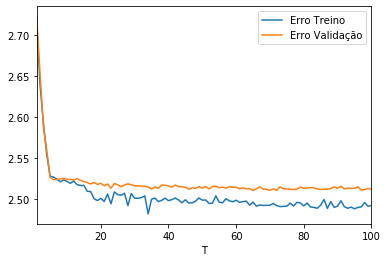

<function show at 0x0149F5D0>


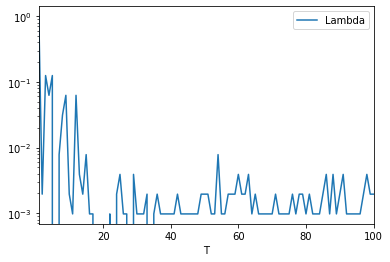

<function show at 0x0149F5D0>


In [6]:
#geração dos relatórios
relatorio_lista=[]
linha=0
for k in range(1,atrasos+1):
    for la in lista_lambda:
        print("Relatorio 1:Lambda {} K {}".format(la,k))
        linha +=1
        x=resultados[(resultados['T']==k)&(resultados['Lambda']==la)].copy()
        x=x.astype({'Erro Treino':float,'Erro Validação':float,'Erro Teste':float})
        x=x[['T','Lambda','Erro Treino','Erro Validação','Erro Teste']]
        relatorio_lista.append((x.mean()).values.tolist())
relatorio1=pd.DataFrame(relatorio_lista,columns=['T','Lambda','Erro Treino','Erro Validação','Erro Teste'])
print(relatorio1)
relatorio_lista=[]
linha=0
for k in range(1,atrasos+1):
    print("Relatorio 2, K {}".format(k))
    linha +=1;
    x=relatorio1[relatorio1['T']==k].copy()
    x=x.astype({'Erro Treino':float,'Erro Validação':float,'Erro Teste':float})
    x=x[['T','Lambda','Erro Treino','Erro Validação','Erro Teste']]
    linha_dados=x.loc[x['Erro Validação'].idxmin()]
    relatorio_lista.append((linha_dados).values.tolist())
relatorio2=pd.DataFrame(relatorio_lista,columns=['T','Lambda','Erro Treino','Erro Validação','Erro Teste'])
print(relatorio2)

print("Relatorio pelo erro médio, o menor erro foi obtido em:")
linha_dados=relatorio2.loc[relatorio2['Erro Validação'].idxmin()]
print(linha_dados)
relatorio2.plot(x='T',y=['Erro Treino','Erro Validação'])
ml.pyplot.show()
print(ml.pyplot.show)
relatorio2.plot(x='T',y=['Lambda'])
ml.pyplot.yscale('log')
ml.pyplot.show()
print(ml.pyplot.show)

Gerando estimativa treinando com todos os dados de treino
Regressão:Lambda 0.001953125 K 65
    T      Lambda Folder Erro Treino Erro Validação
1  65  0.00195312      4     2.49487        2.31819
        Temp
0  12.213205
1  13.962641
2  12.625781
3  15.153347
4  13.929072
   Temp
0  14.8
1  13.3
2  15.6
3  14.5
4  14.3
             Temp
count  365.000000
mean    11.578799
std      3.245151
min      5.962761
25%      8.574886
50%     11.370449
75%     14.088482
max     19.145303
             Temp
count  365.000000
mean    11.669589
std      3.861600
min      2.100000
25%      8.700000
50%     11.400000
75%     14.600000
max     22.100000
      Year       Date  Temp  TempNorm       T-1       T-2       T-3       T-4  \
3280  1990 1990-01-01  14.8  0.250951 -0.068441  0.190114 -0.418251 -0.220532   
3281  1990 1990-01-02  13.3  0.022814  0.250951 -0.068441  0.190114 -0.418251   
3282  1990 1990-01-03  15.6  0.372624  0.022814  0.250951 -0.068441  0.190114   
3283  1990 1990-01-04  14.5  0

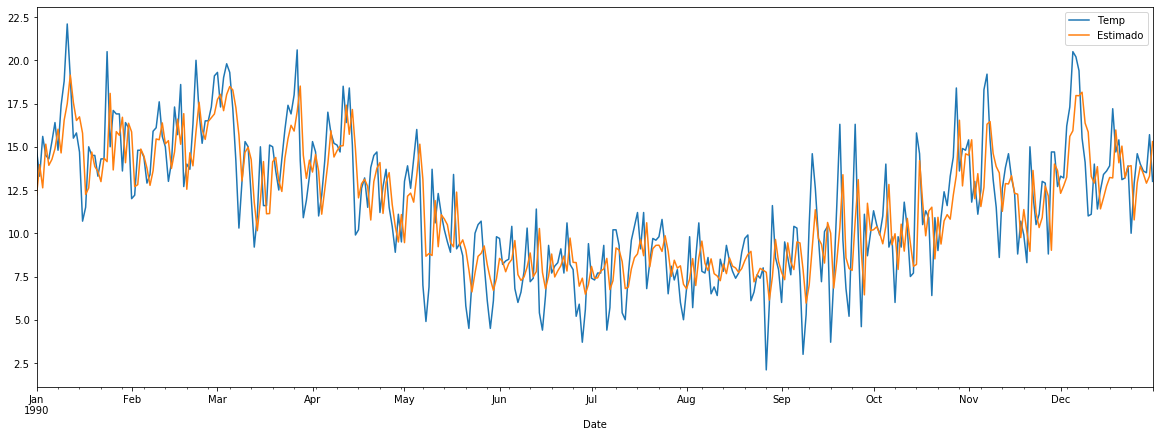

<function show at 0x0149F5D0>


In [17]:
#Geração da estimativa
print("Gerando estimativa treinando com todos os dados de treino")
#como o atraso é covnertido em float temos que voltar ele para int 
k=np.int(linha_dados['T'])
la=np.float(linha_dados['Lambda'])
#gerando uma coluna com o número de folds a partir de uma distribuição normal e inteiros
y_teste=data_test.iloc[:,2:3].copy()
x_teste=data_test.iloc[:,4:9].copy()
print("Regressão:Lambda {} K {}".format(la,k))
linha=1
resultados=pd.DataFrame(columns=['T','Lambda','Folder','Dado Treino','Dado Validação','Matrix','Erro Treino','Erro Validação','Erro Teste'])
resultados.loc[linha,'T']=k
resultados.loc[linha,'Lambda']=la
resultados.loc[linha,'Folder']=f

#Dados treino
x_treino=data_train.iloc[:,4:9].copy()
y_treino=data_train.iloc[:,2:3].copy()

#Dados teste
x_teste=data_test.iloc[:,4:9].copy()
y_teste=data_test.iloc[:,2:3].copy()

# criando a matrix aleatória
w_temp=pd.DataFrame(columns=['w'])
w=pd.DataFrame(columns=['w1'])
variable_list=[]
for t in range(0,k):
    #criando o vetor w     
    for l in range(0,5):
        w_temp.loc[l,'w']=np.random.uniform(0, 1)
    #Normalizando o vetor w para que sua soma seja 1
    w_temp['w']=w_temp['w']/w_temp['w'].sum()
    colum_name='w'+str(t+1)
    variable_name='xl_'+str(t+1)
    variable_list.append(variable_name)
    w[colum_name]=w_temp['w']

#criando as novas variaveis
xl_treino=pd.DataFrame(np.tanh(np.float_(np.dot(x_treino,w))),columns=variable_list)
xl_treino['C']=1;

xl_teste=pd.DataFrame(np.tanh(np.float_(np.dot(x_teste,w))),columns=variable_list)
xl_teste['C']=1;

#criação da matrix identidade
i=np.identity(k+1)
i[k,k]=0

#cálculo do vetor b para regressão
xtx=(xl_treino.values.transpose()).dot(xl_treino.values)
xtxinv=np.linalg.pinv(xtx+la*i)
b=(xtxinv.dot(xl_treino.transpose())).dot(y_treino) 

#erro treino
yh_treino=(xl_treino.values).dot(b)
yh_treino_df=pd.DataFrame(yh_treino,columns=['Temp'])
y_treino.index = pd.RangeIndex(len(y_treino.index))
error_train=mt.sqrt(((yh_treino_df-y_treino)**2).mean())
resultados.loc[linha,'Erro Treino']=error_train

#erro teste
yh_teste=(xl_teste.values).dot(b)
yh_teste_df=pd.DataFrame(yh_teste,columns=['Temp'])
y_teste.index = pd.RangeIndex(len(y_teste.index))
error_valid=mt.sqrt(((yh_teste_df-y_teste)**2).mean())
resultados.loc[linha,'Erro Validação']=error_valid
# leitura dos resultados
print(resultados[['T','Lambda','Folder','Erro Treino','Erro Validação']])
print(yh_teste_df.head())
print(y_teste.head())
print(yh_teste_df.describe())
print(y_teste.describe())
print(data_test.head())
graficoestimado=data_test[['Date','Temp']].copy()
graficoestimado.index = pd.RangeIndex(len(graficoestimado.index))
graficoestimado['Estimado']=yh_teste_df['Temp']
print(graficoestimado.head())
graficoestimado.plot(x='Date',y=['Temp','Estimado'],figsize=(20,7))
ml.pyplot.show()
print(ml.pyplot.show)

In [ ]:
#configuraçõeos do método
ano_teste=1990
atrasos=18
lista_folders=[4]
lista_lambda=[0]
# lista_lambda=[0,0.000976563,0.001953125,0.00390625,0.0078125,0.015625,0.03125,0.0625,0.125,0.25,0.5,1,2,4,8,16,32,64,128,256,512,1024]
#gera os dados de treino e teste
data_train=modified_data[modified_data['Year']!=ano_teste].copy()
# print(data_train.head())
data_test=modified_data[modified_data['Year']==ano_teste].copy()
#inicia os testes
resultados=pd.DataFrame(columns=['Atraso','Lambda','Folder','Dado Treino','Dado Validação','Matrix','Erro Treino','Erro Validação','Erro Teste'])
linha=0
y_test=data_test.iloc[:,2:3].copy()
y_test_final=y_test
y_test_final=y_test_final-y_test
for folders in lista_folders:
    #gerando uma coluna com o número de folds a partir de uma distribuição normal e inteiros
    np.random.seed(9001)
    data_train['fold'] = np.random.randint(1,folders+1,size=len(data_train))
    for la in lista_lambda:
        for f in range(1,folders+1):
            lenght=len(data_train[data_train['fold']==f])       
        for k in range(18,atrasos+1):
            print("Regressão:Lambda {} K {}".format(la,k))
            #dados treino globais
            x_test=data_test.iloc[:,3:k+4].copy()
            
#             print(x_test.head(2))
            for f in range(1,folders+1):
#                 print(k)
                linha+=1
                resultados.loc[linha,'Atraso']=k
                resultados.loc[linha,'Lambda']=la
                resultados.loc[linha,'Folder']=f
                #Dados treino
                x_train=data_train[data_train['fold']!=f]
                x_train=x_train.iloc[:,3:k+4].copy()
#                 print("aquigsgsdf")
#                 print(x_train.head(2))
                y_train=data_train[data_train['fold']!=f]
                y_train=y_train.iloc[:,2:3].copy()
#                 print(y_train.head(2))
                resultados.loc[linha,'Dado Treino']=len(x_train)
                #Dados validação
                x_valid=data_train[data_train['fold']==f]
                x_valid=x_valid.iloc[:,3:k+4].copy()
#                 print(x_valid.head(2))
                y_valid=data_train[data_train['fold']==f]
                y_valid=y_valid.iloc[:,2:3].copy()
#                 print(y_valid.head(2))
                resultados.loc[linha,'Dado Validação']=len(x_valid)
                #criação da matrix identidade
                i=np.identity(k+1)
                i[0,0]=0
                #calculo da inversa
#                 print(x_train)
                xtx=(x_train.transpose()).dot(x_train)
#                 print(xtx.head(20))
#                 print(i)
                rank=np.linalg.matrix_rank(xtx.values)
                if rank==(k+1):
                    message="Sim"
                else:
                    message="Não"
                resultados.loc[linha,'Matrix']=message
                #cálculo do vetor b para regressão
                xtxinv=pd.DataFrame(np.linalg.pinv(xtx.values-la*i), xtx.columns, xtx.index)
                b=(xtxinv.dot(x_train.transpose())).dot(y_train)
                #erro treino
                yh_train=x_train.dot(b)
                error_train=mt.sqrt(((yh_train-y_train)**2).mean())
                resultados.loc[linha,'Erro Treino']=error_train
                #erro validação
                yh_valid=x_valid.dot(b)
                error_valid=mt.sqrt(((yh_valid-y_valid)**2).mean())
                resultados.loc[linha,'Erro Validação']=error_valid
                #erro teste
                yh_test=x_test.dot(b)
                y_test_final=y_test_final+yh_test
                error_tf=mt.sqrt(((yh_test-y_test)**2).mean())
                resultados.loc[linha,'Erro Teste']=error_tf
print(resultados)
grafico_medio=data_test.iloc[:,1:3].copy()
grafico_medio['Estimativas']=y_test_final/4
grafico_medio.plot(x='Date',y=['Temp','Estimativas'],figsize=(15,7))
title="Estimativas geradas com o preditor médio, {} folders, T={}.".format(folders,k)
ml.pyplot.title(title)
print(ml.pyplot.show)